1. Import libraries

In [2]:
# 1. Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import EfficientFrontier, expected_returns, risk_models
from pypfopt import plotting
import matplotlib.pyplot as plt

2. Load forecasted TSLA return

In [4]:
# 2. Load forecasted TSLA returns (from Task 3)
tsla_forecast = pd.read_csv('../data/processed/TSLA_6mo_forecast.csv', index_col=0, parse_dates=True)
forecasted_return = (tsla_forecast.iloc[-1]['Forecast']/tsla_forecast.iloc[0]['Forecast'] - 1)*2  # Annualized


3. Load finance data

In [9]:
data=pd.read_csv("../data/raw/portfolio_data_2015_2025.csv")
print(data.head())

       Ticker                TSLA              TSLA.1              TSLA.2  \
0       Price                Open                High                 Low   
1        Date                 NaN                 NaN                 NaN   
2  2015-07-01  18.073999404907227  18.174667358398438  17.856666564941406   
3  2015-07-02   18.68000030517578  18.829999923706055  18.220666885375977   
4  2015-07-06  18.591999053955078  18.779333114624023  18.420000076293945   

               TSLA.3     TSLA.4                 BND               BND.1  \
0               Close     Volume                Open                High   
1                 NaN        NaN                 NaN                 NaN   
2   17.94333267211914   31518000   60.79418267297806   60.91446000337829   
3  18.667999267578125  107458500   60.93702364900963   61.02723596614089   
4  18.648000717163086   61828500  61.222694629191764  61.222694629191764   

               BND.2               BND.3    BND.4                 SPY  \
0      

4. Calculate expected returns

In [ ]:
import pandas as pd
import numpy as np
from pypfopt import expected_returns

# Assuming 'data' is your DataFrame
# Step 1: Remove the first two rows (header and NaN rows)
data = data.iloc[2:].reset_index(drop=True)

# Step 2: Set the 'Ticker' column as the index (contains dates)
data.set_index('Ticker', inplace=True)

# Step 3: Select only the 'Close' columns for each asset
close_columns = ['TSLA.3', 'BND.3', 'SPY.3']  # Correspond to 'Close' for TSLA, BND, SPY
prices = data[close_columns]

# Step 4: Rename columns to single-level asset names
prices.columns = ['TSLA', 'BND', 'SPY']

# Step 5: Convert data to numeric, handling any non-numeric values
prices = prices.apply(pd.to_numeric, errors='coerce')

# Step 6: Drop any rows with NaN values (if necessary)
prices = prices.dropna()

# Step 7: Ensure the index is datetime
prices.index = pd.to_datetime(prices.index)

# Step 8: Calculate expected returns
annual_returns = expected_returns.mean_historical_return(prices)

# Print the results
print("Annual Returns:")
print(annual_returns)

Annual Returns:
TSLA    0.326590
BND     0.017668
SPY     0.137247
dtype: float64


In [13]:
data.columns

Index(['Ticker', 'TSLA', 'TSLA.1', 'TSLA.2', 'TSLA.3', 'TSLA.4', 'BND',
       'BND.1', 'BND.2', 'BND.3', 'BND.4', 'SPY', 'SPY.1', 'SPY.2', 'SPY.3',
       'SPY.4'],
      dtype='object')

In [ ]:
# Step 9: Assign forecasted return for TSLA 
annual_returns['TSLA'] = forecasted_return

5. Compute covariance matrix

In [ ]:
# 5. Compute covariance matrix
# Compute percentage changes and drop NaN values
returns = prices.pct_change().dropna()

# Step 9: Compute the covariance matrix
cov_matrix = risk_models.sample_cov(returns)

# Print the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
               TSLA          BND           SPY
TSLA  108339.859787   290.668891   -260.823734
BND      290.668891  6925.199823    397.344748
SPY     -260.823734   397.344748  61954.387182


6. Portfolio optimization

<Axes: xlabel='Volatility', ylabel='Return'>

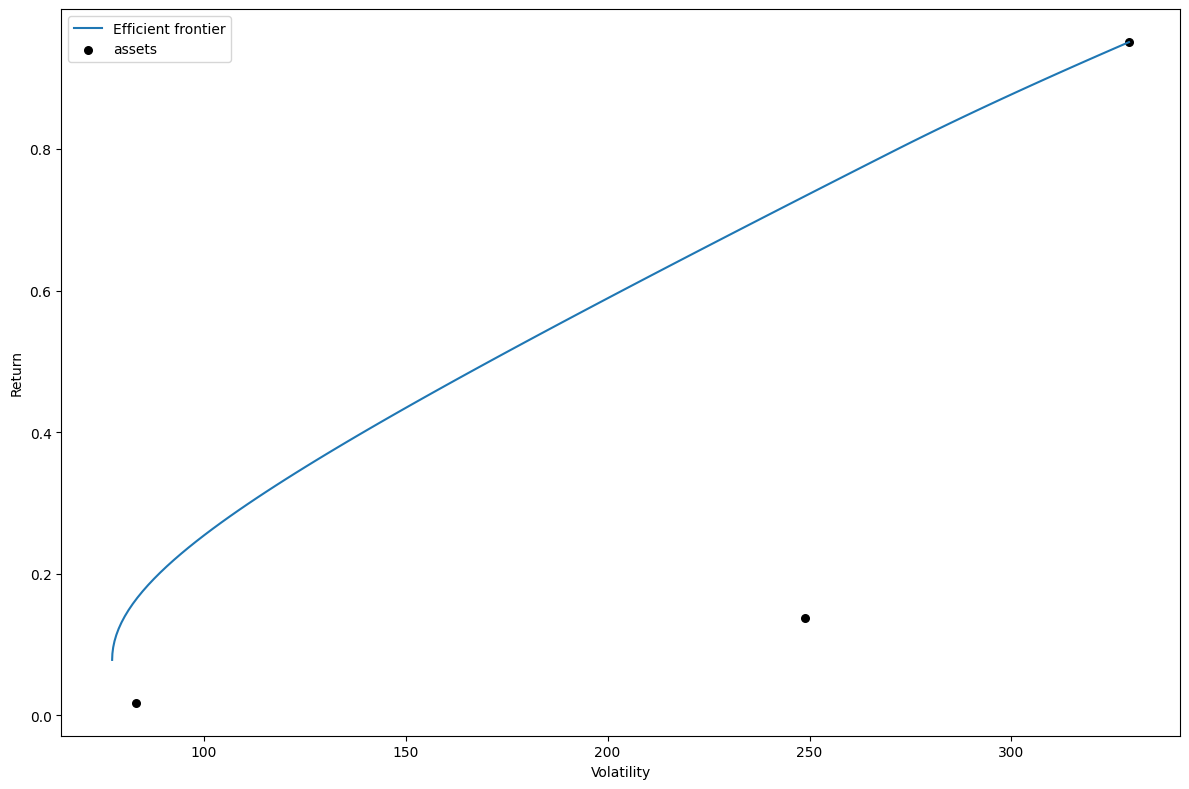

In [18]:
# 6. Portfolio optimization
ef = EfficientFrontier(annual_returns, cov_matrix)
fig, ax = plt.subplots(figsize=(12,8))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

7. Find optimal portfolios

In [20]:
# Create a new EfficientFrontier instance for max_sharpe
ef_max_sharpe = EfficientFrontier(annual_returns, cov_matrix)
ef_max_sharpe.max_sharpe()
max_sharpe_weights = ef_max_sharpe.clean_weights()
max_sharpe_ret, max_sharpe_vol, _ = ef_max_sharpe.portfolio_performance()

# Create a new EfficientFrontier instance for min_volatility
ef_min_vol = EfficientFrontier(annual_returns, cov_matrix)
ef_min_vol.min_volatility()
min_vol_weights = ef_min_vol.clean_weights()
min_vol_ret, min_vol_vol, _ = ef_min_vol.portfolio_performance()

# Print the results
print("Max Sharpe Weights:")
print(max_sharpe_weights)
print(f"Max Sharpe - recovered_data: {max_sharpe_ret}, {max_sharpe_vol}")
print("\nMinimum Volatility Weights:")
print(min_vol_weights)
print(f"Minimum Volatility: {min_vol_ret}, {min_vol_vol}")

Max Sharpe Weights:
OrderedDict({'TSLA': 0.67155, 'BND': 0.15716, 'SPY': 0.17129})
Max Sharpe - recovered_data: 0.6649609706610052, 225.5455044216725

Minimum Volatility Weights:
OrderedDict({'TSLA': 0.0531, 'BND': 0.85569, 'SPY': 0.09122})
Minimum Volatility: 0.07813493961195832, 77.3141058959612


In [23]:
# 8. Plot results
ax.scatter(max_sharpe_vol, max_sharpe_ret, marker='*', s=500, label='Max Sharpe Ratio')
ax.scatter(min_vol_vol, min_vol_ret, marker='*', s=500, label='Min Volatility')
ax.legend()
ax.set_title('Efficient Frontier with Optimal Portfolios')
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Return')

plt.show()

 9. Print recommended portfolio

In [24]:
# 9. Print recommended portfolio
print("\n💡 Recommended Portfolio (Balanced Approach):")
print(f"TSLA: {max_sharpe_weights['TSLA']:.1%}")
print(f"BND: {max_sharpe_weights['BND']:.1%}")
print(f"SPY: {max_sharpe_weights['SPY']:.1%}")
print(f"\nExpected Return: {max_sharpe_ret:.1%}")
print(f"Expected Volatility: {max_sharpe_vol:.1%}")
print(f"Sharpe Ratio: {max_sharpe_ret/max_sharpe_vol:.2f}")


💡 Recommended Portfolio (Balanced Approach):
TSLA: 67.2%
BND: 15.7%
SPY: 17.1%

Expected Return: 66.5%
Expected Volatility: 22554.6%
Sharpe Ratio: 0.00


10. Save weights

In [25]:
# 10. Save weights
pd.Series(max_sharpe_weights).to_csv('../data/processed/optimal_weights.csv')